# DownLoad Dataset

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debmalyadebnath","key":"348451387ec4c57ea753fafed2f44ff2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 773M/778M [00:09<00:00, 154MB/s]
100% 778M/778M [00:09<00:00, 89.9MB/s]


# Import Libraries

In [ ]:
import zipfile
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0,ResNet50,VGG19
from tensorflow.keras.models import Model


# Extract Dataset

In [ ]:
zip_path = "covid19-radiography-database.zip"
extract_path = "covid19_dataset"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [ ]:
base_path = "covid19_dataset/COVID-19_Radiography_Dataset"
print(os.listdir(base_path))

['COVID.metadata.xlsx', 'Normal', 'Lung_Opacity.metadata.xlsx', 'Lung_Opacity', 'Normal.metadata.xlsx', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx', 'README.md.txt', 'COVID']


In [ ]:
for folder in ["train", "val", "test"]:
    for category in ["COVID", "NORMAL", "PNEUMONIA"]:
        os.makedirs(f"dataset/{folder}/{category}", exist_ok=True)

for category, source in {
    "COVID": f"{base_path}/COVID/images",
    "NORMAL": f"{base_path}/Normal/images",
    "PNEUMONIA": f"{base_path}/Viral Pneumonia/images"
}.items():
    files = os.listdir(source)
    random.shuffle(files)

    total = len(files)
    train_end = int(total * 0.7)
    val_end = train_end + int(total * 0.15)

    for i, file in enumerate(files):
        if i < train_end:
            shutil.copy(f"{source}/{file}", f"dataset/train/{category}/{file}")
        elif i < val_end:
            shutil.copy(f"{source}/{file}", f"dataset/val/{category}/{file}")
        else:
            shutil.copy(f"{source}/{file}", f"dataset/test/{category}/{file}")

print("Done!")

Done!


# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

# Load Images in Batch

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10606 images belonging to 3 classes.
Found 2271 images belonging to 3 classes.
Found 2276 images belonging to 3 classes.


# Convolutional Neural Network(CNN)

Build CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN Model Compile

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CNN Model Summary

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,243 (42.61 MB)

 Trainable params: 11,169,795 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

CNN Model Training

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 1236s 4s/step - accuracy: 0.6135 - loss: 5.2368 - val_accuracy: 0.6561 - val_loss: 0.8498
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 1269s 4s/step - accuracy: 0.6545 - loss: 0.9557 - val_accuracy: 0.6631 - val_loss: 2.5753
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 1359s 4s/step - accuracy: 0.6746 - loss: 0.7462 - val_accuracy: 0.7424 - val_loss: 0.5959
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 1304s 4s/step - accuracy: 0.7076 - loss: 0.6917 - val_accuracy: 0.7111 - val_loss: 1.7002
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 1307s 4s/step - accuracy: 0.6980 - loss: 0.6814 - val_accuracy: 0.6742 - val_loss: 7.1247
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 1276s 4s/step - accuracy: 0.7074 - loss: 0.6683 - val_accuracy: 0.7266 - val_loss: 0.6424
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 1352s 4s/step - accuracy: 0.7020 - loss: 0.6937 - val_accuracy: 0.6728 - val_loss: 1.7589
Epoch 8/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 1329s 4s/step - accuracy: 0.7286 - loss: 0.6366 - 

CNN Model Evaluation

In [ ]:
cnn_loss, cnn_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {cnn_acc*100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 774ms/step - accuracy: 0.6804 - loss: 0.8120
Test Accuracy: 67.31%


CNN Model Visulatization

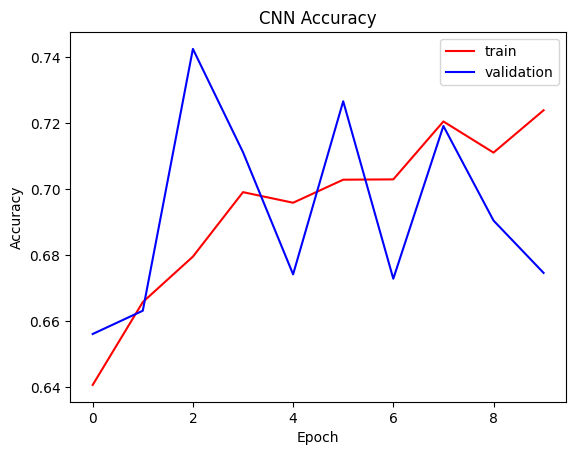

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy')
plt.ylim(0.1,1.0)
plt.legend()
plt.show()

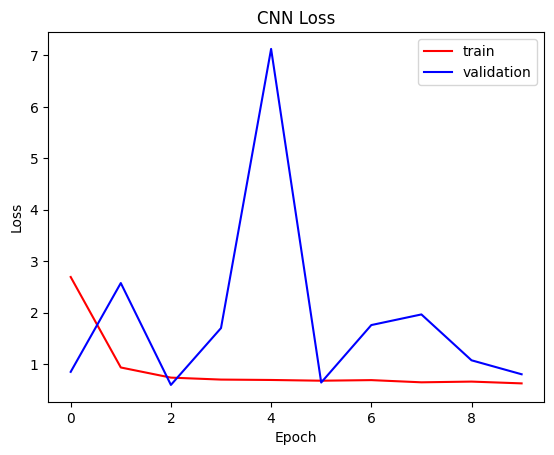

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('CNN Loss')
plt.legend()
plt.show()

# EfficientNet

Load EfficientNetB0 Model

In [ ]:
basemodel=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))
basemodel.trainable=False
x=GlobalAveragePooling2D()(basemodel.output)
x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(3,activation='softmax')(x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


EfficientNetB0 Model Compile

In [ ]:
efficient_model=Model(inputs=basemodel.input,outputs=output)
efficient_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

EfficientNetB0 summary

In [ ]:
efficient_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,221,990 (16.11 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

EfficientNetB0 Model training

In [ ]:
history_efficientnet=efficient_model.fit(train_generator,validation_data=val_generator,epochs=5)

Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - accuracy: 0.6364 - loss: 0.9036 - val_accuracy: 0.6728 - val_loss: 0.8481
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.6719 - loss: 0.8506 - val_accuracy: 0.6728 - val_loss: 0.8247
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - accuracy: 0.6746 - loss: 0.8295 - val_accuracy: 0.6728 - val_loss: 0.8234
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.6717 - loss: 0.8287 - val_accuracy: 0.6728 - val_loss: 0.8232
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 678s 2s/step - accuracy: 0.6749 - loss: 0.8218 - val_accuracy: 0.6728 - val_loss: 0.8241
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.6668 - loss: 0.8348 - val_accuracy: 0.6728 - val_loss: 0.8232
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.6823 - loss: 0.8143 - val_accuracy: 0.6728 - val_loss: 0.8236
Epoch 8/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.6803 - loss: 0.8181 - val_accu

EfficientNetB0 Model Evaluation

In [ ]:
efficient_loss, efficient_acc = efficient_model.evaluate(test_generator)
print(f"Test Accuracy: {efficient_acc*100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6757 - loss: 0.8167
Test Accuracy: 67.22%


EfficientNet50 Model Visualization

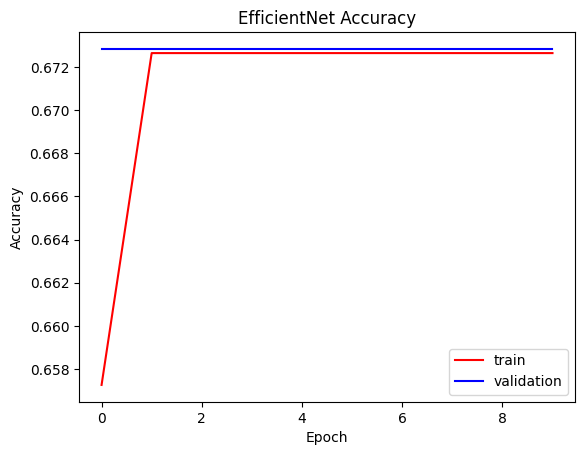

In [ ]:
plt.plot(history_efficientnet.history['accuracy'],color='red',label='train')
plt.plot(history_efficientnet.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1,1.0)
plt.title('EfficientNet Accuracy')
plt.legend()
plt.show()

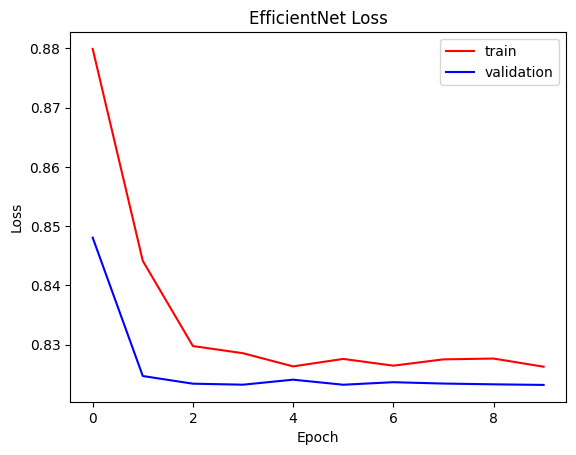

In [ ]:
plt.plot(history_efficientnet.history['loss'],color='red',label='train')
plt.plot(history_efficientnet.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('EfficientNet Loss')
plt.legend()
plt.show()

# ResNet50

Load ResNet50 Model

In [ ]:
basemodel=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
basemodel.trainable=False
x=GlobalAveragePooling2D()(basemodel.output)
x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(3,activation='softmax')(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


ResNet50 Model Compile

In [ ]:
resnet_model=Model(inputs=basemodel.input,outputs=output)
resnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

ResNet50 Summary

In [ ]:
resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,858,435 (91.01 MB)

 Trainable params: 270,723 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

ResNet50 Model Training

In [ ]:
history_resnet=resnet_model.fit(train_generator,validation_data=val_generator,epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 2429s 7s/step - accuracy: 0.6146 - loss: 0.9505 - val_accuracy: 0.6728 - val_loss: 0.8334
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 2387s 7s/step - accuracy: 0.6733 - loss: 0.8473 - val_accuracy: 0.6728 - val_loss: 0.8309
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 2395s 7s/step - accuracy: 0.6810 - loss: 0.8215 - val_accuracy: 0.6728 - val_loss: 0.8234
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 2432s 7s/step - accuracy: 0.6717 - loss: 0.8285 - val_accuracy: 0.6728 - val_loss: 0.8232
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 2495s 8s/step - accuracy: 0.6727 - loss: 0.8274 - val_accuracy: 0.6728 - val_loss: 0.8234
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 2463s 7s/step - accuracy: 0.6687 - loss: 0.8287 - val_accuracy: 0.6728 - val_loss: 0.8232
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 2416s 7s/step - accuracy: 0.6759 - loss: 0.8199 - val_accuracy: 0.6728 - val_loss: 0.8237
Epoch 8/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 2383s 7s/step - accuracy: 0.6802 - loss: 0.8153 - 

ResNet50 Model Evaluation

In [ ]:
resnet_loss, resnet_acc = resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {resnet_acc*100:.2f}%")

ResNet50 Model Visualization

In [ ]:
plt.plot(history_resnet.history['accuracy'],color='red',label='train')
plt.plot(history_resnet.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1,1.0)
plt.title('ResNet Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_resnet.history['loss'],color='red',label='train')
plt.plot(history_resnet.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('ResNet Loss')
plt.legend()
plt.show()

# VGG19

Load VGG19 Model

In [ ]:
basemodel=VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))
basemodel.trainable=False
x=GlobalAveragePooling2D()(basemodel.output)
x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(3,activation='softmax')(x)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


VGG19 Model Compile

In [ ]:
vgg19_model=Model(inputs=basemodel.input,outputs=output)
vgg19_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

VGG19 Model summary

In [ ]:
vgg19_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,098,499 (76.67 MB)

 Trainable params: 74,115 (289.51 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

VGG19 Model Training

In [ ]:
history_vgg19=vgg19_model.fit(train_generator,validation_data=val_generator,epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 9973s 30s/step - accuracy: 0.6412 - loss: 0.8714 - val_accuracy: 0.7257 - val_loss: 0.6068
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 9802s 30s/step - accuracy: 0.6902 - loss: 0.6766 - val_accuracy: 0.7521 - val_loss: 0.5505
Epoch 3/10


VGG19 Model Evaluation

In [ ]:
vgg19_loss, vgg19_acc = resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {vgg19_acc*100:.2f}%")

VGG19 Model Visualization

In [ ]:
plt.plot(history_vgg19.history['accuracy'],color='red',label='train')
plt.plot(history_vgg19.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1,1.0)
plt.title('VGG19 Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_vgg19.history['loss'],color='red',label='train')
plt.plot(history_vgg19.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('VGG19 Loss')
plt.legend()
plt.show()

# Model Visualization

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],label='CNN Accuracy')
plt.plot(history_efficientnet.history['accuracy'], label='EfficientNet Accuracy')
plt.plot(history_resnet.history['accuracy'], label='ResNet50 Accuracy')
plt.plot(history_vgg19.history['accuracy'], label='VGG19 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1.0)
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='CNN Loss')
plt.plot(history_efficientnet.history['loss'], label='EfficientNet Loss')
plt.plot(history_resnet.history['loss'], label='ResNet50 Loss')
plt.plot(history_vgg19.history['loss'], label='VGG19 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.1, 1.0)
plt.legend()
plt.title('Model Loss')

plt.show()


In [ ]:
models = ['CNN','EfficientNet','ResNet','VGG19']
accuracies = [cnn_acc,efficient_acc,resnet_acc, vgg19_acc]
plt.bar(models, accuracies)
plt.title('Model TestCase Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1.0)
plt.show()

In [ ]:
models = ['CNN','EfficientNet','ResNet','VGG19']
accuracies = [cnn_loss,efficient_loss,resnet_loss, vgg19_loss]
plt.bar(models, accuracies)
plt.title('Model TestCase Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.ylim(0.1, 1.0)
plt.show()